In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from astropy.io import fits

# Importing example data:
toi = pd.read_csv('toi_example.csv')
tic_catalog = pd.read_csv('tic_catalog_example.csv')

# Getting it into an sqlite database:
engine = create_engine('sqlite://', echo=False)

toi.to_sql('toi', con=engine, index=False)
tic_catalog.to_sql('tic_catalog', con=engine, index=False)

In [21]:
# Pulling data from sql database:
toi = pd.read_sql_table('toi', engine).drop(columns='Unnamed: 0')
tic_catalog = pd.read_sql_table(
    'tic_catalog', engine).drop(columns='Unnamed: 0')

# Assembling data needed for model:
df = toi.merge(tic_catalog, on='TIC_ID')
df

,TIC_ID,TOI,Epoch_(BJD),Period_(days),Duration_(hours),Depth_(mmag),Planet_Radius_(R_Earth),Planet_Insolation_(Earth_Flux),Planet_Equil_Temp_(K),Planet_SNR,...,MH,rad,mass,rho,lum,d,ebv,numcont,contratio,priority
0,231663901,101.01,2.458326e+06,1.430401,1.638765,22.436284,13.145008,1193.379561,1499.044062,0.887868,...,NaN,0.890774,1.050000,1.485550,0.822462,375.3100,0.033360,90.0,0.084449,0.000566
1,149603524,102.01,2.458326e+06,4.411943,3.776425,15.285609,15.397243,708.767112,1315.968940,474.380950,...,0.240000,1.214270,1.280000,0.714926,2.216167,175.6310,0.020257,971.0,0.016392,0.007091
2,336732616,103.01,2.458327e+06,3.547854,3.494333,11.377523,14.581841,1212.004376,1504.858953,0.800299,...,NaN,1.276160,1.270000,0.611063,2.417336,411.2110,0.044639,112.0,0.023094,0.000415
3,231670397,104.01,2.458328e+06,4.087445,5.590140,3.900662,12.652102,1672.217546,1630.958624,0.808662,...,NaN,2.218670,1.160000,0.106213,6.237656,316.6780,0.030207,81.0,0.004832,0.000773
4,144065872,105.01,2.458327e+06,2.184659,2.869426,12.928190,12.514586,985.883704,1429.144596,0.886027,...,NaN,1.238240,1.030000,0.542529,1.518417,137.5440,0.006338,55.0,0.003545,0.002210
5,38846515,106.01,2.458327e+06,2.849380,3.776111,8.121677,9.061380,1311.315373,1534.781437,278.009500,...,NaN,1.774570,1.440000,0.257683,5.830600,364.4110,0.023686,87.0,0.068780,0.002905
6,92352620,107.01,2.458328e+06,3.950054,4.557506,14.207005,18.775574,1098.209548,1468.219722,0.860200,...,0.220000,1.710360,1.140000,0.227845,3.584022,211.2110,0.046266,118.0,0.637895,0.000955
7,289793076,108.01,2.458328e+06,3.043839,2.660993,26.534793,13.999502,400.955287,1141.284018,0.820267,...,NaN,0.809868,0.950000,1.788470,0.519416,421.8550,0.048850,NaN,NaN,NaN
8,29344935,109.01,2.458326e+06,2.766737,2.568721,17.172409,11.661768,433.482954,1163.758204,0.834164,...,NaN,0.984866,0.930000,0.973535,0.721826,513.0110,0.053547,NaN,NaN,NaN
9,281459670,110.01,2.458328e+06,3.174305,2.723339,17.075061,13.668801,662.491006,1293.941810,100.352080,...,-0.100000,1.157060,1.030000,0.664921,1.318858,342.1400,0.011021,47.0,2.934236,0.000552


In [22]:
from sklearn.model_selection import train_test_split

# Separating confirmed planets from false positives:
df['TFOPWG_Disposition'] = df[
    'TFOPWG_Disposition'].replace({'KP': 1, 'CP': 1, 'FP': 0})

# Creating confirmed planets dataframe:
cp_df = df[df['TFOPWG_Disposition'] == 1]

# Creating false positives dataframe:
fp_df = df[df['TFOPWG_Disposition'] == 0]

# Train/test split on both dataframes:
cp_train, cp_test = train_test_split(cp_df, random_state=42)
fp_train, fp_test = train_test_split(fp_df, random_state=42)

# Combining training dataframes:
train = cp_train.append(fp_train)
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

# Combining test dataframes:
test = cp_test.append(fp_test)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)

# Dropping columns from training dataframe that aren't used in model:
X_train = train.drop(columns=['TIC_ID', 'TOI', 'TFOPWG_Disposition'])
# Getting labels for training data:
y_train = train['TFOPWG_Disposition'].astype(int)

# Dropping columns from test dataframe that aren't used in model:
X_test = test.drop(columns=['TIC_ID', 'TOI', 'TFOPWG_Disposition'])
# Getting labels for test data:
y_test = test['TFOPWG_Disposition'].astype(int)

In [23]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Setting up model architecture for neural net:
def create_model():
    # Instantiate model:
    model = Sequential()
    # Add input layer:
    model.add(Dense(20, input_dim=33, activation='relu'))
    # Add hidden layer:
    model.add(Dense(20, activation='relu'))
    # Add output layer:
    model.add(Dense(1, activation='sigmoid'))
    # Compile model:
    model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])
    return model

# Putting neural net in a pipeline:
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    RobustScaler(),
    KerasClassifier(build_fn=create_model, verbose=2)
)

# Fitting the neural net:
pipeline.fit(X_train,
             y_train,
             kerasclassifier__batch_size=5,
             kerasclassifier__epochs=50,
             kerasclassifier__validation_split=.2,
             kerasclassifier__verbose=2)

# Printing train and test accuracy:
print('\n\n')
print(f'Train Accuracy Score:', pipeline.score(X_train, y_train), '\n')
print(f'Test Accuracy Score:', pipeline.score(X_test, y_test))

Train on 224 samples, validate on 57 samples
Epoch 1/50
224/224 - 0s - loss: 0.8045 - acc: 0.4375 - val_loss: 0.8316 - val_acc: 0.4737
Epoch 2/50
224/224 - 0s - loss: 0.6910 - acc: 0.5357 - val_loss: 0.7369 - val_acc: 0.5439
Epoch 3/50
224/224 - 0s - loss: 0.6462 - acc: 0.6295 - val_loss: 0.6874 - val_acc: 0.6667
Epoch 4/50
224/224 - 0s - loss: 0.6095 - acc: 0.6830 - val_loss: 0.6649 - val_acc: 0.7368
Epoch 5/50
224/224 - 0s - loss: 0.5779 - acc: 0.7812 - val_loss: 0.6546 - val_acc: 0.8070
Epoch 6/50
224/224 - 0s - loss: 0.5468 - acc: 0.7991 - val_loss: 0.6463 - val_acc: 0.7719
Epoch 7/50
224/224 - 0s - loss: 0.5172 - acc: 0.8080 - val_loss: 0.6609 - val_acc: 0.7544
Epoch 8/50
224/224 - 0s - loss: 0.4874 - acc: 0.8304 - val_loss: 0.6866 - val_acc: 0.7719
Epoch 9/50
224/224 - 0s - loss: 0.4601 - acc: 0.8304 - val_loss: 0.7144 - val_acc: 0.7544
Epoch 10/50
224/224 - 0s - loss: 0.4330 - acc: 0.8527 - val_loss: 0.7287 - val_acc: 0.7544
Epoch 11/50
224/224 - 0s - loss: 0.4141 - acc: 0.8527 

95/95 - 0s
95/95 - 0s


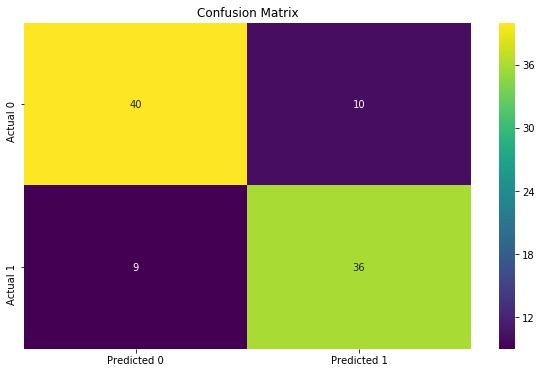

In [24]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Defining function to plot confusion matrix:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}'  for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    fig = plt.figure(figsize=(10,6))
    plt.title('Confusion Matrix')
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

# Getting predictions and prediction probabilities:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

# Plotting confusion matrix:
plot_confusion_matrix(y_test, y_pred);

In [25]:
import pickle

# Isolating neural net in pipeline and saving the classifier:
pipeline.named_steps['kerasclassifier'].model.save('keras_classifier.h5')

# Removing neural net from pipeline to isolate preprocessing steps:
pipeline.named_steps['kerasclassifier'].model = None

# Pickling preprocessing steps:
pickle.dump(pipeline, open('tess_pipeline.pkl', 'wb'))

In [26]:
from tensorflow.keras.models import load_model

# Loading pipeline with preprocessing steps:
tess_pipeline = pickle.load(open('tess_pipeline.pkl', 'rb'))

# Loading neural net and inserting into to pipeline:
tess_pipeline.named_steps['kerasclassifier'].model = load_model(
    'keras_classifier.h5')

In [27]:
# Preparing to make predictions for entire dataframe:
X = df.drop(columns=['TIC_ID', 'TOI', 'TFOPWG_Disposition'])

# Getting predictions and prediction probabilities for entire dataframe:
y_pred_full = tess_pipeline.predict(X)
y_pred_proba_full = tess_pipeline.predict_proba(X)

1184/1184 - 0s
1184/1184 - 0s


In [28]:
# Printing predictions for entire dataframe:
y_pred_full

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [29]:
# Printing prediction probabilities for entire dataframe:
y_pred_proba_full

array([[4.3163121e-02, 9.5683688e-01],
       [0.0000000e+00, 1.0000000e+00],
       [3.5886526e-02, 9.6411347e-01],
       ...,
       [8.4877014e-04, 9.9915123e-01],
       [1.4875293e-02, 9.8512471e-01],
       [7.9970121e-02, 9.2002988e-01]], dtype=float32)